In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv("preprocessed_dataset1.csv")

# Assuming you have text_messages and department_labels arrays
text_messages = dataset["Message"][:-2]#[:3000]
department_labels = dataset["Department"][:-2]#[:3000]

# Convert department labels to numerical format
label_map = {label: index for index, label in enumerate(set(department_labels))}
numerical_labels = [label_map[label] for label in department_labels]

# Split dataset into training and validation sets
train_text, val_text, train_labels, val_labels = train_test_split(text_messages, numerical_labels, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_labels))




2024-03-20 03:50:31.127081: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
for example, label in train_dataset.take(3):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'aslm pak gub tolong jalan pantura losari brebes banyak lobang tolong cpt di perbaiki'
label:  2
text:  b'ketua rt di desa cikandang kec kersana kab brebes ada yg sudah tahun tidak diganti mohon diperhatikan'
label:  1
text:  b'assalamu alaikum bpk ganjar pranowo pak ganjar mohon untuk marka jalan dri klonengan sampai arah bumiayu tidak ada pak trimakasih'
label:  2


2024-03-20 03:51:30.508105: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'saya tidak bisa daftar akun diwebsite layananonline dukcapil kemendagri go id dengan notifikasi bukan sebagai kepala keluarga padahal sudah jelas di kk pun saya adalah kepala keluarga mohon ditindaklanjuti'
 b'pak gubernur yang terhormat saya warga desa cikandang kec kersana kabp brebes saya bikin e ktp dr tahun sampe sekarang belum jadi apakah ada kesalahan sampe saat ini belum jadi mohon bantu pak terima kasih liki fauzi warga brebes'
 b'assalamualaikum pak mau bertanya perihal pembuatan ktp kenapa di kecamatan banjarharjo masih saja kehabisan blanko ya pak mohon penjelasannya kenapa masih terjadi ']

labels:  [2 2 2]


In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'di', 'saya', 'pak', 'brebes', 'dan', 'ktp', 'ada',
       'yg', 'desa', 'mohon', 'tidak', 'yang', 'jalan', 'sudah', 'untuk',
       'ini', 'kami', 'kecamatan'], dtype='<U16')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example



array([[  3,  12,  27,   1,   1,   1,   1, 236, 488,   1,   1,  28,   1,
        326, 255, 217, 303, 116,  15, 540,   2, 149, 181,   3, 290, 217,
        303,  11, 407,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  4,  21,  13, 193,   3,  34,  10,   1,  41, 216,   1,   5,   3,
         78,  30,   7, 120,  39, 271,

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'saya tidak bisa daftar akun diwebsite layananonline dukcapil kemendagri go id dengan notifikasi bukan sebagai kepala keluarga padahal sudah jelas di kk pun saya adalah kepala keluarga mohon ditindaklanjuti'
Round-trip:  saya tidak bisa [UNK] [UNK] [UNK] [UNK] dukcapil kemendagri [UNK] [UNK] dengan [UNK] bukan sebagai kepala keluarga padahal sudah jelas di kk pun saya adalah kepala keluarga mohon ditindaklanjuti                                                                                                                                

Original:  b'pak gubernur yang terhormat saya warga desa cikandang kec kersana kabp brebes saya bikin e ktp dr tahun sampe sekarang belum jadi apakah ada kesalahan sampe saat ini belum jadi mohon bantu pak terima kasih liki fauzi warga brebes'
Round-trip:  pak gubernur yang terhormat saya warga desa [UNK] kec kersana [UNK] brebes saya bikin e ktp dr tahun sampe sekarang belum jadi apakah ada kesalahan sampe saat ini belum jadi mohon bantu 

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label_map), activation='softmax')
])

In [ ]:
total_train_samples = len(train_text)
total_val_samples = len(val_text)

# Calculate the number of epochs
# Assuming each epoch goes through the entire training dataset
num_epochs = 10

# Calculate steps per epoch
# Steps per epoch should be total_train_samples divided by batch size
steps_per_epoch = total_train_samples // BATCH_SIZE

# Calculate validation steps
# Validation steps should be total_val_samples divided by batch size
validation_steps = total_val_samples // BATCH_SIZE

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 6
Validation steps: 1


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=15,
                    validation_data=val_dataset,
                    validation_steps=1
                    )

Epoch 1/15
7/7 [==============================] - 14s 971ms/step - loss: 1.3672 - accuracy: 0.3559 - val_loss: 1.3540 - val_accuracy: 0.3281
Epoch 2/15
7/7 [==============================] - 2s 356ms/step - loss: 1.3015 - accuracy: 0.3851 - val_loss: 1.3831 - val_accuracy: 0.3281
Epoch 3/15
7/7 [==============================] - 3s 369ms/step - loss: 1.2660 - accuracy: 0.3851 - val_loss: 1.3178 - val_accuracy: 0.3281
Epoch 4/15
7/7 [==============================] - 3s 430ms/step - loss: 1.1987 - accuracy: 0.3874 - val_loss: 1.2546 - val_accuracy: 0.3281
Epoch 5/15
7/7 [==============================] - 3s 422ms/step - loss: 1.0323 - accuracy: 0.4505 - val_loss: 1.1025 - val_accuracy: 0.5000
Epoch 6/15
7/7 [==============================] - 3s 381ms/step - loss: 0.8796 - accuracy: 0.7725 - val_loss: 1.2198 - val_accuracy: 0.6562
Epoch 7/15
7/7 [==============================] - 3s 389ms/step - loss: 0.6827 - accuracy: 0.9009 - val_loss: 1.2437 - val_accuracy: 0.7031
Epoch 8/15
7/7 [===

In [ ]:
test_loss, test_acc = model.evaluate(val_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2/2 [==============================] - 0s 111ms/step - loss: 0.7619 - accuracy: 0.8036
Test Loss: 0.7618647813796997
Test Accuracy: 0.8035714030265808


1/1 [==============================] - 0s 21ms/step
[[0.03907271 0.00397248 0.9515612  0.00539361]]
{'dinas pekerjaan umum bina marga cipta karya': 0, 'dinas pekerjaan umum sumber daya air dan penataan ruang': 1, 'dinas pemberdayaan masyarakat, desa, kependudukan dan pencatatan sipil': 2, 'badan pengelola pendapatan daerah': 3}


In [ ]:
sample_text = ('biaya untuk penerbitan stnk baru dinaikkan oleh oknum tidak bertanggung  jawab')
predictions = model.predict(np.array([sample_text]))
print(predictions)
#print(label_map)

# Get the predicted label with the highest probability
predicted_label_index = np.argmax(predictions)

print("Probability:", predictions[0][predicted_label_index])

# Function to get the key from a given value
def get_key_from_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None  # If value is not found in the dictionary


# Example usage
value_to_find = np.argmax(predictions)
key_for_value = get_key_from_value(label_map, value_to_find)
if key_for_value is not None:
    print("Numeric label", value_to_find, "is:", key_for_value)
else:
    print("Value", value_to_find, "not found in the dictionary.")

1/1 [==============================] - 0s 34ms/step
[[0.13267916 0.12450421 0.19180511 0.55101156]]
Probability: 0.55101156
Numeric label 3 is: badan pengelola pendapatan daerah


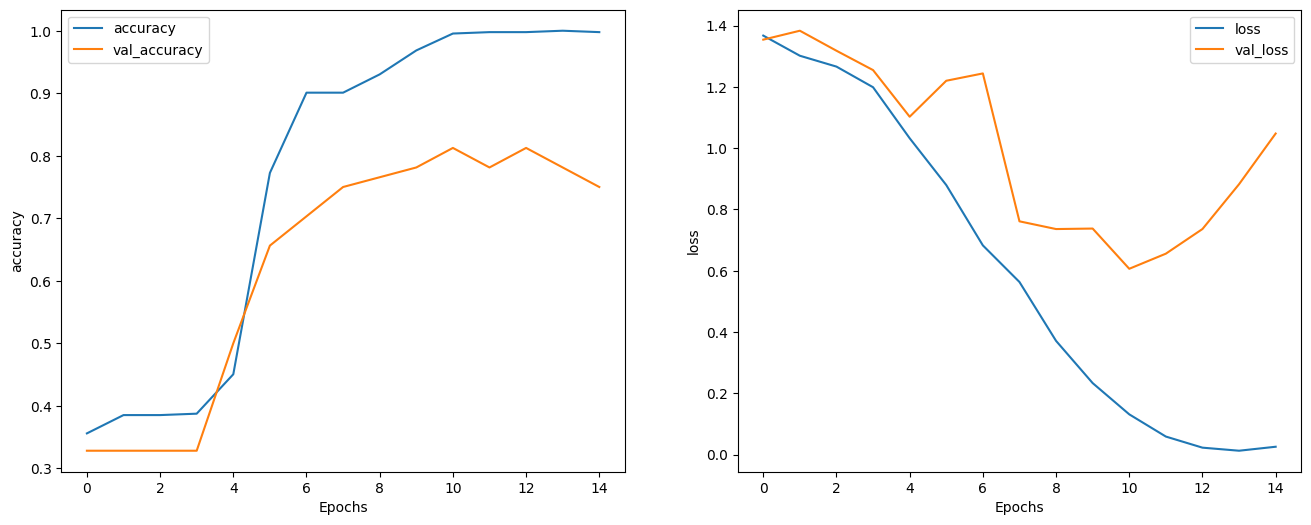

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')


#gajadi


In [ ]:
dataset = pd.read_csv("preprocessed_dataset.csv")

# Assuming you have text_messages and department_labels arrays
text_messages = dataset["Message"][:3000]
department_labels = dataset["Department"][:3000]

# Tokenize text messages
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(text_messages)
text_sequences = tokenizer.texts_to_sequences(text_messages)

# Pad text sequences to ensure consistent length
max_sequence_length = 250  # Choose a suitable maximum sequence length
padded_text_sequences = pad_sequences(text_sequences, maxlen=max_sequence_length, padding='post')

# Convert department labels to numerical format
label_map = {label: index for index, label in enumerate(set(department_labels))}
numerical_labels = [label_map[label] for label in department_labels]

# Split dataset into training and validation sets
train_text, val_text, train_labels, val_labels = train_test_split(padded_text_sequences, numerical_labels, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_labels))

# Batch and shuffle datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(len(train_text)).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)


In [ ]:
# Define your neural network model using TensorFlow's Keras API
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(len(label_map), activation='softmax')
])



In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset)

In [ ]:
print(label_map)

{'dinas kelautan dan perikanan': 0, 'biro perekonomian': 1, 'dinas pemberdayaan masyarakat, desa, kependudukan dan pencatatan sipil': 2, 'dinas sosial': 3, 'dinas pekerjaan umum sumber daya air dan penataan ruang': 4, 'kabupaten purbalingga': 5, 'dinas kesehatan': 6, 'biro umum': 7, 'bank jateng': 8, 'dinas pendidikan dan kebudayaan': 9, 'kepolisian daerah jawa tengah': 10, 'badan kepegawaian daerah': 11, 'dinas pertanian dan perkebunan': 12, 'dinas komunikasi dan informatika': 13, 'dinas energi dan sumber daya mineral': 14, 'bpjs kesehatan': 15, 'dinas pekerjaan umum bina marga cipta karya': 16, 'dinas penanaman modal dan pelayanan terpadu satu pintu': 17, 'kabupaten brebes': 18, 'biro kesejahteraan rakyat': 19, 'inspektorat': 20, 'dinas perhubungan': 21, 'bpjs ketenagakerjaan kanwil jateng dan diy': 22, 'kanwil kemenag provinsi jawa tengah': 23, 'dinas peternakan dan kesehatan hewan': 24, 'dinas lingkungan hidup dan kehutanan': 25, 'balai besar pelaksanaan jalan nasional jawa tengah 

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example raw text data
text = #

# Preprocess the text data
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
sequences = tokenizer.texts_to_sequences([text])

# Padding
max_length = 100  # Specify the maximum sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Assuming 'model' is your trained model
# Make predictions
predictions = model.predict(padded_sequences)
# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print the predicted labels
print(predicted_labels)



1/1 [==============================] - 0s 244ms/step
[18  3 32  2 16 18 18 18  2  6 18 19  4 16 18 18 18 18 25 14 21 18  4 18
 18 30 18  3  2 27 18 18]


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')


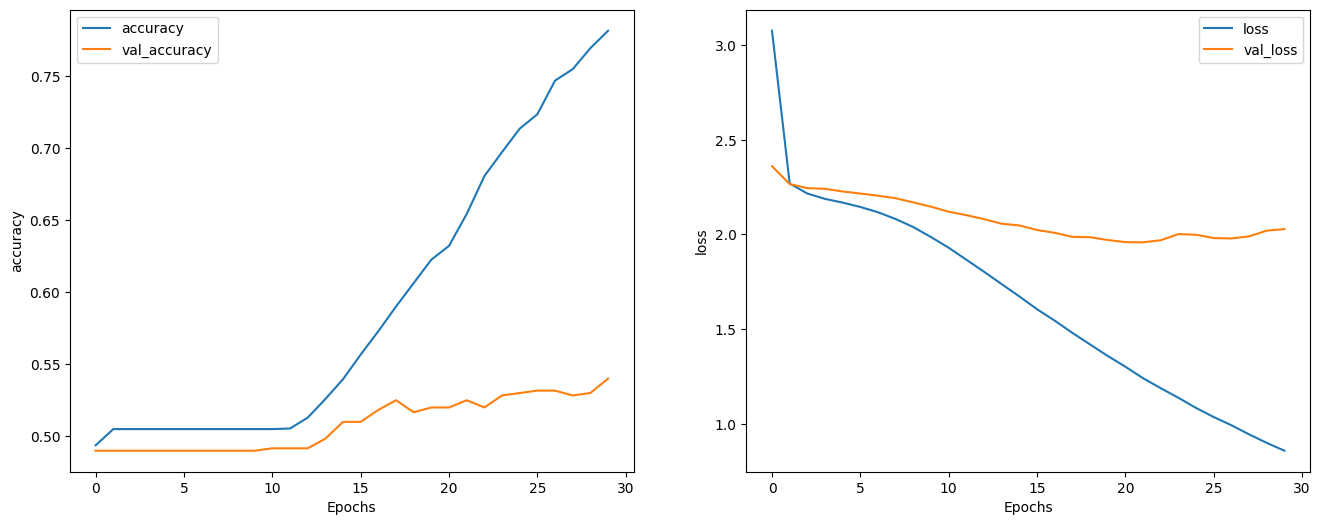